# Day 4: Arbitrage Pricing Theory (APT)

## Learning Objectives
- Understand APT theoretical framework
- Use Principal Component Analysis to identify factors
- Build a multi-factor APT model
- Compare statistical factors vs economic factors

## Key Formula
$$E[R_i] = R_f + \sum_{k=1}^{K} \beta_{ik} \lambda_k$$

Where $\lambda_k$ is the risk premium for factor $k$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("ARBITRAGE PRICING THEORY (APT) - DAY 4")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

ARBITRAGE PRICING THEORY (APT) - DAY 4
Data: 1834 days, 63 assets


## 1. APT vs CAPM Theoretical Background

| Aspect | CAPM | APT |
|--------|------|-----|
| Factors | Single (Market) | Multiple (unspecified) |
| Derivation | Equilibrium | No-arbitrage |
| Assumptions | Mean-variance | Fewer restrictions |
| Factors | Observable | Statistical/Economic |

## 2. Extract Statistical Factors via PCA

In [2]:
# Standardize returns
scaler = StandardScaler()
returns_std = scaler.fit_transform(returns)

# Apply PCA
n_components = 10
pca = PCA(n_components=n_components)
factors_pca = pca.fit_transform(returns_std)

# Convert to DataFrame
factor_names = [f'PC{i+1}' for i in range(n_components)]
factors_df = pd.DataFrame(factors_pca, index=returns.index, columns=factor_names)

# Variance explained
var_explained = pca.explained_variance_ratio_
cum_var = np.cumsum(var_explained)

print("\n" + "="*60)
print("PCA VARIANCE EXPLAINED")
print("="*60)
print(f"{'Factor':<10} {'Variance %':<15} {'Cumulative %':<15}")
print("-"*40)
for i in range(n_components):
    print(f"PC{i+1:<9} {var_explained[i]*100:<15.2f} {cum_var[i]*100:<15.2f}")


PCA VARIANCE EXPLAINED
Factor     Variance %      Cumulative %   
----------------------------------------
PC1         38.52           38.52          
PC2         7.67            46.19          
PC3         6.60            52.79          
PC4         4.59            57.38          
PC5         4.14            61.52          
PC6         2.46            63.98          
PC7         2.06            66.04          
PC8         1.76            67.80          
PC9         1.56            69.36          
PC10        1.46            70.82          


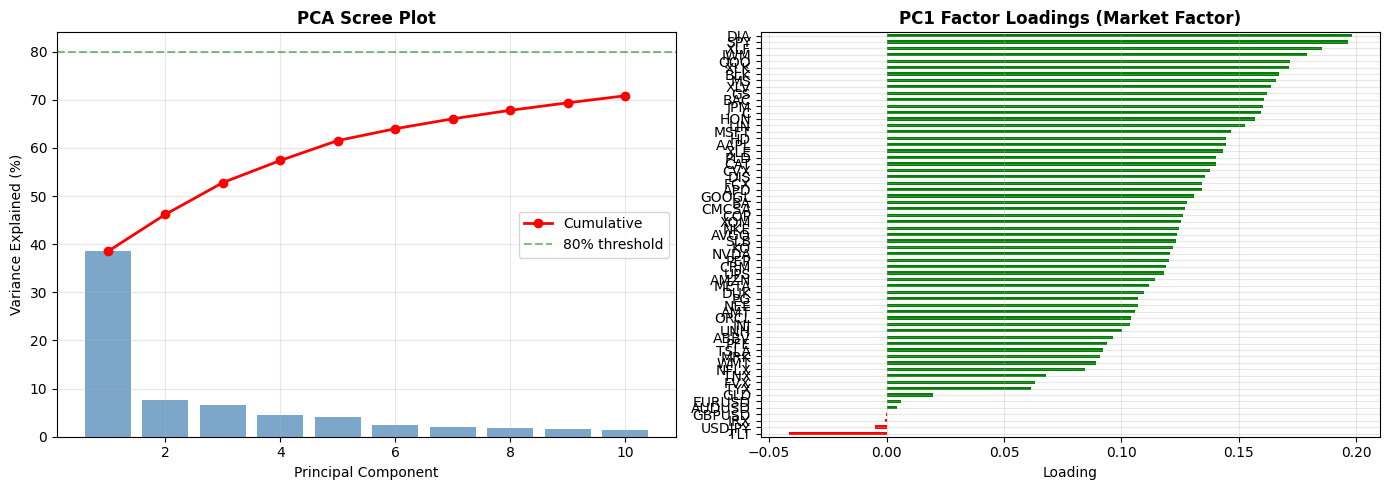


💡 PC1 typically represents the market factor with similar loadings across stocks


In [3]:
# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax1 = axes[0]
ax1.bar(range(1, n_components + 1), var_explained * 100, color='steelblue', alpha=0.7)
ax1.plot(range(1, n_components + 1), cum_var * 100, 'ro-', linewidth=2, label='Cumulative')
ax1.axhline(80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('PCA Scree Plot', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Factor loadings for PC1
ax2 = axes[1]
loadings = pd.Series(pca.components_[0], index=returns.columns).sort_values()
colors = ['red' if x < 0 else 'green' for x in loadings]
loadings.plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('Loading')
ax2.set_title('PC1 Factor Loadings (Market Factor)', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 PC1 typically represents the market factor with similar loadings across stocks")

## 3. Run APT Regression

In [4]:
def run_apt_regression(stock_returns, factors, n_factors=5):
    """Run APT regression with specified number of PCA factors."""
    daily_rf = RISK_FREE_RATE / TRADING_DAYS
    excess_returns = stock_returns - daily_rf
    
    X = sm.add_constant(factors.iloc[:, :n_factors])
    model = sm.OLS(excess_returns, X).fit()
    
    return model

# Test with different numbers of factors
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ']

print("\n" + "="*60)
print("APT REGRESSION: VARYING NUMBER OF FACTORS")
print("="*60)

results = []
for n_factors in [1, 3, 5, 7, 10]:
    print(f"\n{n_factors} Factors:")
    print(f"{'Stock':<10} {'R²':<10} {'Alpha':<12}")
    print("-"*35)
    
    for stock in test_stocks:
        if stock in returns.columns:
            model = run_apt_regression(returns[stock], factors_df, n_factors)
            alpha = model.params['const'] * TRADING_DAYS
            
            results.append({
                'stock': stock,
                'n_factors': n_factors,
                'r2': model.rsquared,
                'alpha': alpha
            })
            
            print(f"{stock:<10} {model.rsquared:<10.4f} {alpha:<12.2%}")


APT REGRESSION: VARYING NUMBER OF FACTORS

1 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       0.5054     26.00%      
MSFT       0.5230     20.60%      
JPM        0.6249     17.81%      
XOM        0.3814     12.72%      
JNJ        0.2616     6.87%       

3 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       0.6317     26.00%      
MSFT       0.7181     20.60%      
JPM        0.7313     17.81%      
XOM        0.6259     12.72%      
JNJ        0.5521     6.87%       

5 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       0.6494     26.00%      
MSFT       0.7536     20.60%      
JPM        0.7342     17.81%      
XOM        0.7350     12.72%      
JNJ        0.5879     6.87%       

7 Factors:
Stock      R²         Alpha       
-----------------------------------
AAPL       0.6642     26.00%      
MSFT       0.7701     20.60%      
JPM        0.8389     17.81%  

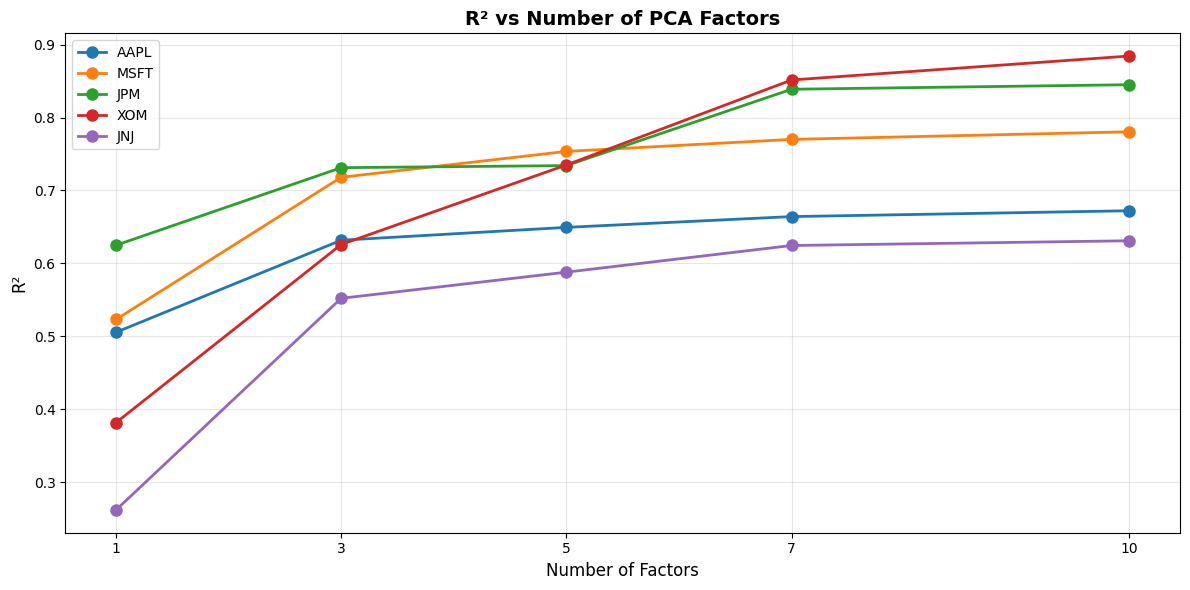


💡 R² increases with more factors, but be cautious of overfitting!


In [5]:
# Visualize R² vs number of factors
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 6))

for stock in test_stocks:
    stock_data = results_df[results_df['stock'] == stock]
    ax.plot(stock_data['n_factors'], stock_data['r2'], 'o-', linewidth=2, label=stock, markersize=8)

ax.set_xlabel('Number of Factors', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('R² vs Number of PCA Factors', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks([1, 3, 5, 7, 10])

plt.tight_layout()
plt.show()

print("\n💡 R² increases with more factors, but be cautious of overfitting!")

## 4. Factor Interpretation

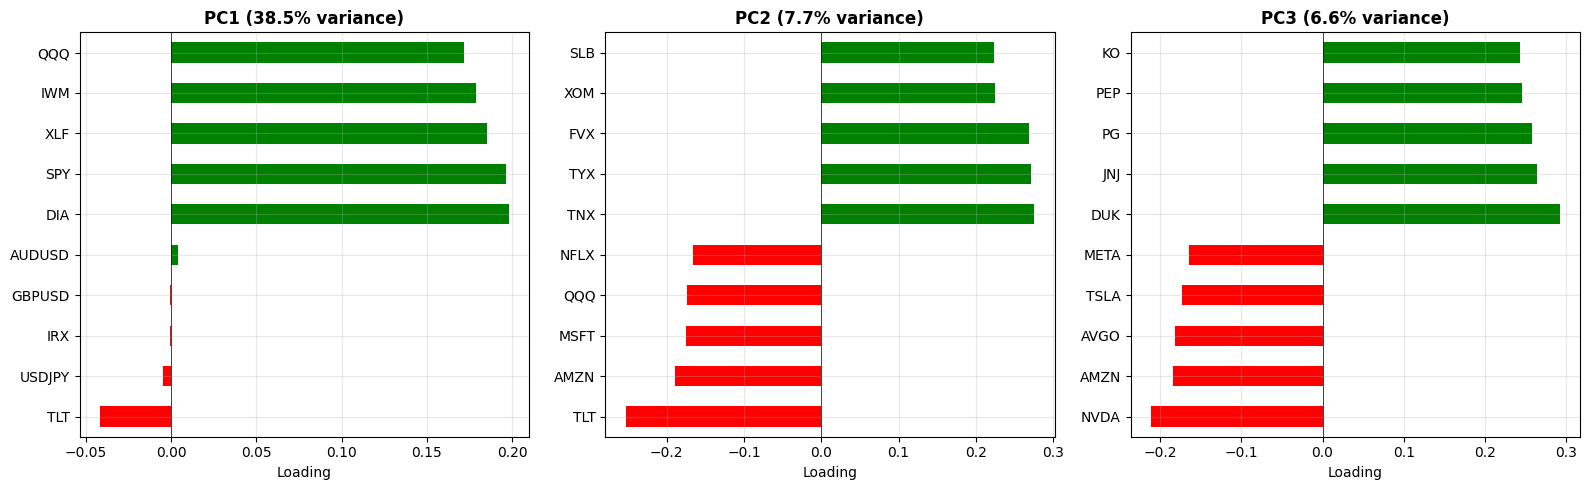


📊 Factor Interpretation:
   PC1: Usually the market factor (all loadings similar)
   PC2-3: Often sector or style factors


In [6]:
# Analyze top 3 factors
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    loadings = pd.Series(pca.components_[i], index=returns.columns)
    
    # Get top and bottom 5 stocks
    top5 = loadings.nlargest(5)
    bottom5 = loadings.nsmallest(5)
    
    combined = pd.concat([bottom5, top5])
    colors = ['red' if x < 0 else 'green' for x in combined]
    
    combined.plot(kind='barh', ax=ax, color=colors)
    ax.set_xlabel('Loading')
    ax.set_title(f'PC{i+1} ({var_explained[i]*100:.1f}% variance)', fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Factor Interpretation:")
print("   PC1: Usually the market factor (all loadings similar)")
print("   PC2-3: Often sector or style factors")

In [7]:
# Correlate PCA factors with market returns
market_proxy = returns['SPY']

print("\n" + "="*50)
print("PCA FACTORS vs MARKET RETURNS CORRELATION")
print("="*50)
print(f"{'Factor':<10} {'Correlation':<15}")
print("-"*25)

for i in range(5):
    corr = np.corrcoef(factors_df[f'PC{i+1}'], market_proxy)[0, 1]
    print(f"PC{i+1:<9} {corr:<15.4f}")

print("\n💡 High PC1-Market correlation confirms PC1 ≈ Market Factor")


PCA FACTORS vs MARKET RETURNS CORRELATION
Factor     Correlation    
-------------------------
PC1         0.9684         
PC2         -0.1714        
PC3         -0.1184        
PC4         0.0291         
PC5         0.0124         

💡 High PC1-Market correlation confirms PC1 ≈ Market Factor


## 5. APT Model Selection

In [8]:
# Use information criteria for model selection
print("\n" + "="*60)
print("MODEL SELECTION: AIC/BIC")
print("="*60)

model_selection = []

for stock in test_stocks:
    if stock in returns.columns:
        print(f"\n{stock}:")
        print(f"{'Factors':<10} {'R²':<10} {'AIC':<12} {'BIC':<12}")
        print("-"*45)
        
        for n_factors in [1, 3, 5, 7, 10]:
            model = run_apt_regression(returns[stock], factors_df, n_factors)
            print(f"{n_factors:<10} {model.rsquared:<10.4f} {model.aic:<12.2f} {model.bic:<12.2f}")
            
            model_selection.append({
                'stock': stock,
                'n_factors': n_factors,
                'r2': model.rsquared,
                'aic': model.aic,
                'bic': model.bic
            })

model_df = pd.DataFrame(model_selection)

print("\n💡 Lower AIC/BIC is better - balances fit vs complexity")


MODEL SELECTION: AIC/BIC

AAPL:
Factors    R²         AIC          BIC         
---------------------------------------------
1          0.5054     -10584.85    -10573.83   
3          0.6317     -11121.81    -11099.76   
5          0.6494     -11207.98    -11174.89   
7          0.6642     -11283.05    -11238.94   
10         0.6722     -11321.36    -11260.71   

MSFT:
Factors    R²         AIC          BIC         
---------------------------------------------
1          0.5230     -10982.69    -10971.66   
3          0.7181     -11943.38    -11921.32   
5          0.7536     -12186.43    -12153.34   
7          0.7701     -12309.40    -12265.29   
10         0.7806     -12388.64    -12327.98   

JPM:
Factors    R²         AIC          BIC         
---------------------------------------------
1          0.6249     -11226.81    -11215.79   
3          0.7313     -11834.77    -11812.71   
5          0.7342     -11850.33    -11817.25   
7          0.8389     -12765.06    -12720.95   


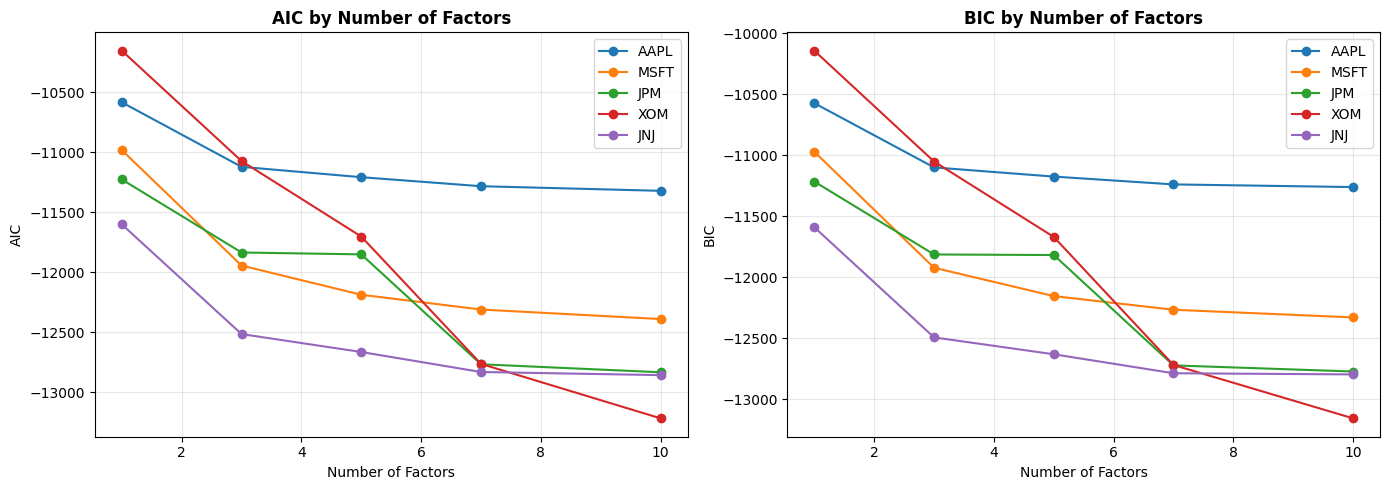

In [9]:
# Visualize AIC/BIC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AIC
ax1 = axes[0]
for stock in test_stocks:
    stock_data = model_df[model_df['stock'] == stock]
    ax1.plot(stock_data['n_factors'], stock_data['aic'], 'o-', label=stock)
ax1.set_xlabel('Number of Factors')
ax1.set_ylabel('AIC')
ax1.set_title('AIC by Number of Factors', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# BIC
ax2 = axes[1]
for stock in test_stocks:
    stock_data = model_df[model_df['stock'] == stock]
    ax2.plot(stock_data['n_factors'], stock_data['bic'], 'o-', label=stock)
ax2.set_xlabel('Number of Factors')
ax2.set_ylabel('BIC')
ax2.set_title('BIC by Number of Factors', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Statistical vs Economic Factors

In [10]:
print("\n" + "="*60)
print("STATISTICAL vs ECONOMIC FACTORS")
print("="*60)

print("""
STATISTICAL FACTORS (PCA-based):
✅ Advantages:
   - Data-driven, no prior assumptions
   - Maximizes variance explained
   - Orthogonal by construction

❌ Disadvantages:
   - Difficult to interpret economically
   - May not be stable over time
   - Sample-specific

ECONOMIC FACTORS (e.g., Fama-French):
✅ Advantages:
   - Clear economic interpretation
   - Stable, well-documented
   - Widely used in practice

❌ Disadvantages:
   - May not fully capture risk
   - Factors may be correlated
   - Requires fundamental data
""")


STATISTICAL vs ECONOMIC FACTORS

STATISTICAL FACTORS (PCA-based):
✅ Advantages:
   - Data-driven, no prior assumptions
   - Maximizes variance explained
   - Orthogonal by construction

❌ Disadvantages:
   - Difficult to interpret economically
   - May not be stable over time
   - Sample-specific

ECONOMIC FACTORS (e.g., Fama-French):
✅ Advantages:
   - Clear economic interpretation
   - Stable, well-documented
   - Widely used in practice

❌ Disadvantages:
   - May not fully capture risk
   - Factors may be correlated
   - Requires fundamental data



## Key Takeaways

1. **APT is more flexible** than CAPM - multiple factors
2. **PCA extracts statistical factors** that maximize variance
3. **PC1 ≈ Market factor** in most cases
4. **Model selection** (AIC/BIC) helps choose number of factors
5. **Tradeoff** between statistical fit and interpretability

---
*Next: Day 5 - Factor Exposure Analysis*